In [44]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap
from jax import random
import matplotlib.pyplot as plt

import poppy

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

shift = np.fft.fftshift
fft   = np.fft.fft2
ifft  = np.fft.ifft2
fftfreq = np.fft.fftfreq

dtor = np.pi/180.0

import warnings
warnings.filterwarnings("ignore")


In [45]:
osys = poppy.OpticalSystem()
osys.add_pupil(poppy.CircularAperture(radius=3))    # pupil radius in meters
osys.add_detector(pixelscale=0.025, fov_arcsec=0.75)  # image plane coordinates in arcseconds



In [46]:
osys.planes[1].pixelscale

0.025

In [47]:
osys.input_wavefront().amplitude

DeviceArray([[1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             ...,
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.],
             [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [48]:
osys.intermediate_wfs

In [49]:
psf,intermediate = osys.propagate_mono(2e-6)

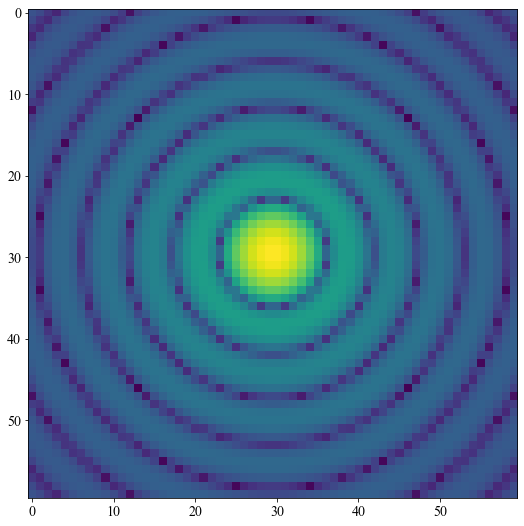

In [50]:
plt.imshow(psf.amplitude**0.25)

In [51]:
def objective(wavelength):
    psf,intermediate = osys.propagate_mono(wavelength*1e-6)   
    return (np.sum(psf.amplitude**2.))

objective(2.)

DeviceArray(0.96685994, dtype=float32)

In [52]:
thisgrad = grad(objective)
thisgrad(2.0)

DeviceArray(-0.01927825, dtype=float32)

In [53]:
%%time
print(thisgrad(2.0))

-0.019278252
CPU times: user 772 ms, sys: 106 ms, total: 878 ms
Wall time: 704 ms


## Now can we calculate a UV plane?

In [54]:
from poppy.matrixDFT import minimal_dft

In [55]:
arcsec2rad = np.pi/180./3600.
# experimental mathematics for the UV coords
arcsec2rad*psf.pixelscale * psf.shape[0] / 2.e-6*2*osys.planes[0].pupil_diam 

DeviceArray(21.816616, dtype=float32)

In [56]:
def calc_uv(wavefront,osys,npix=128):
    nlamd = arcsec2rad*wavefront.pixelscale * wavefront.shape[0] / 2.e-6*2*osys.planes[0].pupil_diam
    pupil = wavefront.amplitude**2.
    return minimal_dft(pupil, nlamd, npix)

In [57]:
uv = calc_uv(psf,osys)

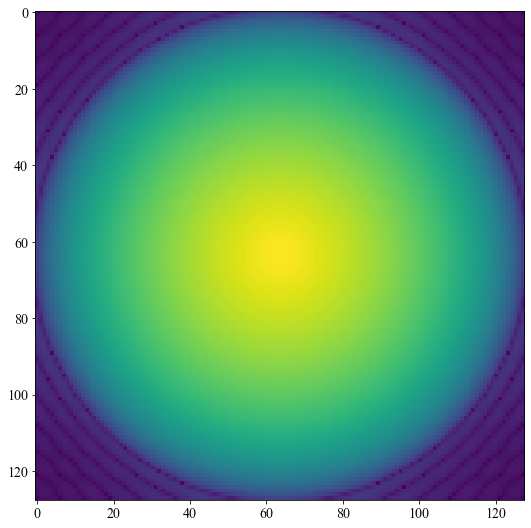

In [58]:
plt.imshow(np.abs(uv)**0.25)

## Let's try propagating some aberrations

In [59]:
wfe = poppy.ZernikeWFE(radius=1.0, coefficients=[0, 3e-8, 2e-7])


In [60]:
RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.025 # arcsec / pix
FOV = 1 # arcsec
NWAVES = 1.0


In [61]:
coefficients_sequence = [0, 0, 0, 0, 125e-9]

osys = poppy.OpticalSystem()
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)
thinlens = poppy.ZernikeWFE(radius=RADIUS, coefficients=coefficients_sequence)
osys.add_pupil(thinlens)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(2e-6)

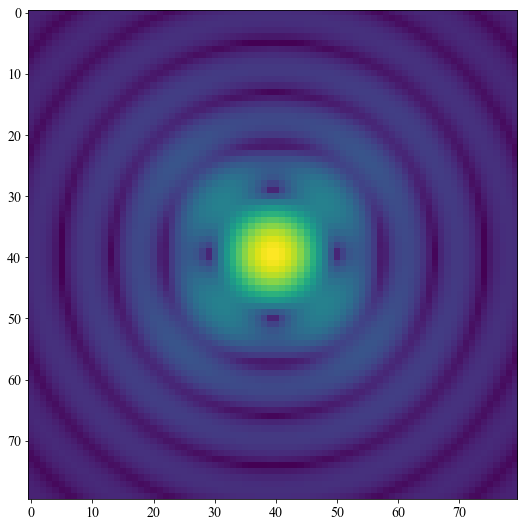

In [62]:
plt.imshow(psf.amplitude**0.5)

In [63]:
osys.planes[0].pupil_diam # m

4.0

In [64]:
psf.pixelscale # arcsec/pixel

DeviceArray(0.0125, dtype=float32)

## Non Zernike basis?

In [65]:
osys.planes[0].transmission

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [66]:
class mywavefront(poppy.AnalyticOpticalElement):
    def __init__(self, wavelength, pupil, phasescreen, **kwargs):
        """ If your optic has adjustible parameters, then save them as attributes here """
        super().__init__()
        self.pupil = pupil
        self.wavelength = wavelength
        self.phasescreen = phasescreen

    def get_opd(self,wave):
        opd = self.phasescreen
        return opd

    def get_transmission(self, wave):
        transmission = self.pupil.get_transmission(wave)
        return transmission

    # behind the scenes poppy  will calculate:
    #    phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)


In [67]:
wfe = mywavefront(2.e-6,osys.planes[0],np.zeros_like(osys.planes[0].transmission))

In [68]:
pupil = osys.planes[0]


In [69]:
osys.planes[0].sample

<bound method AnalyticOpticalElement.sample of <poppy.optics.CircularAperture object at 0x1c1e4bbd90>>

In [70]:
NPIX = 128

RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.07 # arcsec / pix
FOV = 3 # arcsec
NWAVES = 1.0
NPIX = 128

osys = poppy.OpticalSystem(npix=NPIX)
circular_aperture = poppy.CircularAperture(radius=RADIUS)
osys.add_pupil(circular_aperture)

wf = osys.input_wavefront()
wfe = mywavefront(2.e-6,osys.planes[0],np.zeros_like(wf.coordinates()[0]))
osys.add_pupil(wfe)
osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

psf,intermediate = osys.propagate_mono(2e-6)

In [71]:
wf.amplitude.shape

(128, 128)

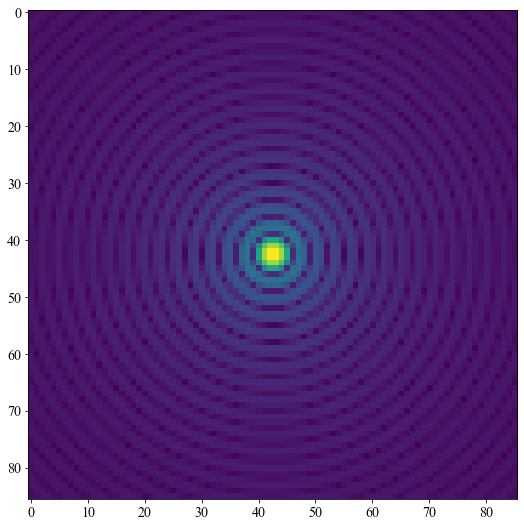

In [72]:
plt.imshow(psf.amplitude**0.5)

## Now let's try to autodiff this

In [73]:
NPIX = 128

RADIUS = 2.0 # meters
WAVELENGTH = 2.0e-6 # meters
PIXSCALE = 0.07 # arcsec / pix
FOV = 3 # arcsec
NWAVES = 1.0


def psf_from_phasescreen(phasescreen,wavel=WAVELENGTH):
    osys = poppy.OpticalSystem(npix=NPIX)
    circular_aperture = poppy.CircularAperture(radius=RADIUS)
    osys.add_pupil(circular_aperture)

    wf = osys.input_wavefront()
    wfe = mywavefront(wavel,osys.planes[0],phasescreen)
    osys.add_pupil(wfe)
    osys.add_detector(pixelscale=PIXSCALE, fov_arcsec=FOV)

    psf,intermediate = osys.propagate_mono(wavel)
    return psf,osys

def end_to_end(phasescreen):
    psf, osys = psf_from_phasescreen(phasescreen)
    return calc_uv(psf,osys,npix=NPIX)

def uv_phase(phasescreen):
    return np.angle(end_to_end(phasescreen))

zero_phase = np.zeros_like(wf.coordinates()[0])

output = uv_phase(zero_phase)

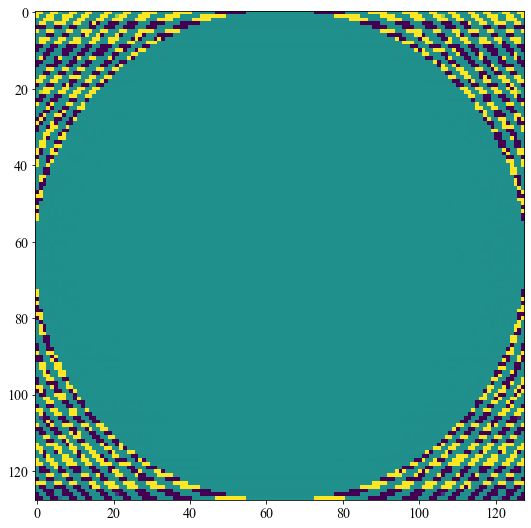

In [74]:
plt.imshow(output)

In [75]:
from jax import jacfwd, jacrev
from time import time as clock

In [76]:
phasegrad = jacrev(uv_phase)

In [77]:
%%time 
thisgrad = phasegrad(zero_phase)


CPU times: user 4.25 s, sys: 6.9 s, total: 11.1 s
Wall time: 4.7 s


In [78]:
tic = clock()
print(thisgrad.sum())
toc = clock()
print(toc-tic)

64512.0
121.17166900634766


In [79]:
print(toc-tic)

121.17166900634766


In [80]:
otf = end_to_end(zero_phase)

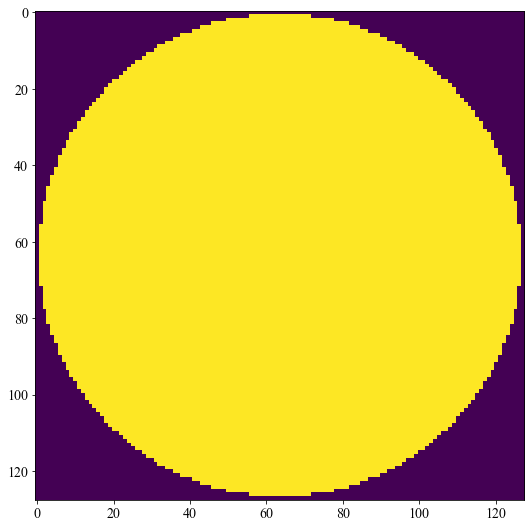

In [81]:
support = np.abs(otf) > 1e-5
plt.imshow(support)

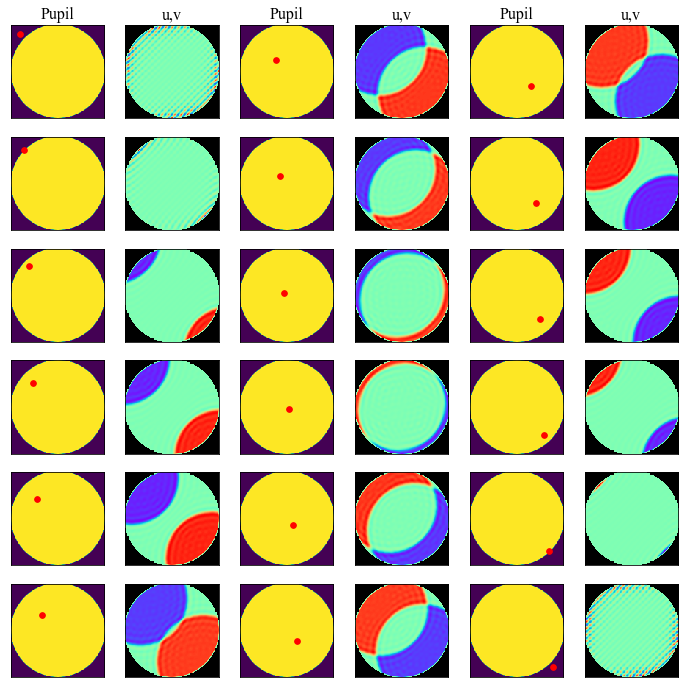

In [82]:
fig, ax = plt.subplots(6,6,figsize=(12, 12))
columns = 2
rows = 6
indices = 12
fs = 16


for j in [0,2,4]:
    for i in range(rows):
#         print(indices)
#         ax[i,1+j].imshow(thisgrad[indices,indices,:,:],cmap=phasemap)
        phases = onp.copy(thisgrad[indices,indices,:,:])
        pupil_trans = osys.planes[0].transmission
        phases[pupil_trans==0] = np.nan
        ax[i,1+j].imshow(phases,cmap=phasemap)

        ax[i,1+j].set_xticks([])
        ax[i,1+j].set_yticks([])
        if i ==0:
            ax[i,1+j].set_title('u,v',fontsize=fs)
            ax[i,j].set_title('Pupil',fontsize=fs)

        ax[i,j].imshow(pupil_trans)
        ax[i,j].scatter(indices,indices,s=32,c='r')
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])

        indices += 6

# plt.savefig('jacobian.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/anoroc/paper/jacobian.pdf',bbox_inches='tight')

In [83]:
transfer_martinache = thisgrad[support>0,:,:][:,pupil_trans>0]

In [84]:
%%time
u1, s1, v1 = np.linalg.svd(transfer_martinache,full_matrices=False)

CPU times: user 331 ms, sys: 361 ms, total: 692 ms
Wall time: 177 ms


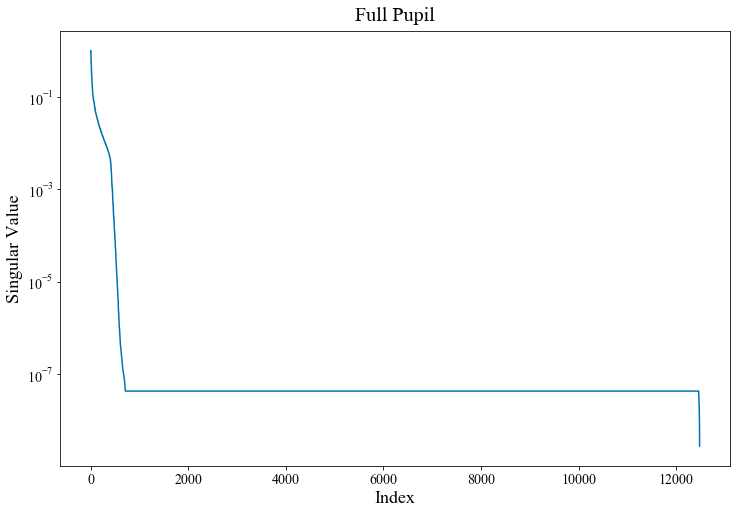

In [90]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(s1/s1[0])
plt.yscale('log')
plt.ylabel('Singular Value')
plt.xlabel('Index')
# plt.title('Kernel Phase Singular Value Spectrum',fontsize=24,y=1.01)
plt.title('Full Pupil',y=1.01,fontsize=20)
# plt.savefig('kerphi_singular.png',bbox_inches='tight')
plt.savefig('/Users/benjaminpope/code/anoroc/paper/kerphi_singular.pdf',bbox_inches='tight')